In [1]:
import pandas as pd
import os
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/John-Blodgett/CSC466-Project/main/total_data.csv')
# df = df.drop('file dist of bytes', axis=1)
df['hash dist'] = df['hash dist'].apply(eval)
df['file dist of bytes'] = df['file dist of bytes'].apply(eval)
df_dist = pd.DataFrame(df['hash dist'].to_list(), 
                       index=df.index, 
                       columns=['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f'])
df_dist['hash type'] = df['hash type']

df.append(df_dist)
df.drop(['hash dist', 'hash'], axis=1, inplace=True)

df[['consecutiveCount', 'file size (bytes)']] = StandardScaler().fit_transform(df[['consecutiveCount', 'file size (bytes)']])

df = pd.get_dummies(df, columns=['file type', 'consecutiveByte'])

df

,file dist of bytes,consecutiveCount,hash type,hash len,hash 0 bits,hash 1 bits,hash len bits,file size (bytes),file type_.jpg,file type_.json,file type_.pdf,file type_.txt,"consecutiveByte_b""'""",consecutiveByte_b' ',consecutiveByte_b'!',"consecutiveByte_b'""'",consecutiveByte_b'(',consecutiveByte_b'-',consecutiveByte_b'.',consecutiveByte_b'0',consecutiveByte_b'1',consecutiveByte_b'2',consecutiveByte_b'3',consecutiveByte_b'4',consecutiveByte_b'5',consecutiveByte_b'6',consecutiveByte_b'7',consecutiveByte_b'8',consecutiveByte_b'9',consecutiveByte_b';',consecutiveByte_b'>',consecutiveByte_b'?',consecutiveByte_b'@',consecutiveByte_b'A',consecutiveByte_b'B',consecutiveByte_b'D',consecutiveByte_b'O',consecutiveByte_b'P',consecutiveByte_b'Q',consecutiveByte_b'U',...,consecutiveByte_b'\x11',consecutiveByte_b'\x14',consecutiveByte_b'\x16',consecutiveByte_b'\x1a',consecutiveByte_b'\x1e',consecutiveByte_b'\x82',consecutiveByte_b'\x83',consecutiveByte_b'\x84',consecutiveByte_b'\x88',consecutiveByte_b'\x8a',consecutiveByte_b'\x8f',consecutiveByte_b'\x91',consecutiveByte_b'\x92',consecutiveByte_b'\x9e',consecutiveByte_b'\xa3',consecutiveByte_b'\xa4',consecutiveByte_b'\xa5',consecutiveByte_b'\xaa',consecutiveByte_b'\xb3',consecutiveByte_b'\xd1',consecutiveByte_b'\xdd',consecutiveByte_b'\xe7',consecutiveByte_b'\xee',consecutiveByte_b'\xf4',consecutiveByte_b'\xf5',consecutiveByte_b'\xff',consecutiveByte_b'_',consecutiveByte_b'a',consecutiveByte_b'b',consecutiveByte_b'c',consecutiveByte_b'd',consecutiveByte_b'e',consecutiveByte_b'f',consecutiveByte_b'h',consecutiveByte_b'i',consecutiveByte_b'o',consecutiveByte_b'p',consecutiveByte_b's',consecutiveByte_b'w',consecutiveByte_b'~'
0,"[185, 71, 61, 64, 62, 43, 59, 58, 47, 49, 108,...",-0.079771,SHA-1,40,69,91,160,-0.226642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[192, 78, 55, 54, 53, 54, 61, 70, 50, 55, 115,...",-0.079771,SHA-256,64,133,123,256,-0.226927,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[181, 80, 57, 57, 63, 60, 63, 70, 44, 44, 115,...",-0.079771,SHA-3-256,64,116,140,256,-0.226016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"[215, 68, 51, 73, 52, 57, 52, 55, 40, 43, 102,...",-0.079771,MD5,32,55,73,128,-0.226521,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"[191, 90, 60, 66, 56, 59, 66, 60, 53, 54, 102,...",-0.079771,SHA-256,64,117,139,256,-0.226609,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,"[10194, 3869, 3826, 3705, 3466, 3743, 3592, 38...",-0.061607,SHA-256,64,125,131,256,0.140832,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5246,"[29855, 14763, 15433, 17860, 14182, 15818, 156...",0.175344,SHA-256,64,134,122,256,1.485487,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5247,"[3220, 3164, 3107, 3076, 3088, 3066, 3136, 319...",-0.038490,SHA-256,64,121,135,256,0.238327,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5248,"[1053, 896, 765, 76

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('hash type', axis=1), df['hash type'], test_size=0.2, random_state=0)

# reduce dimensionality of file byte dist (from 256 to around 2 or whatever happens to capture 90% of the variance)
X_train_file_dist = pd.DataFrame(X_train['file dist of bytes'].to_list(),  index=X_train.index)
X_test_file_dist = pd.DataFrame(X_test['file dist of bytes'].to_list(),  index=X_test.index)

scaler = StandardScaler()
scaler.fit(X_train_file_dist)
X_train_file_dist = pd.DataFrame(scaler.transform(X_train_file_dist), index=X_train.index)
X_test_file_dist = pd.DataFrame(scaler.transform(X_test_file_dist), index=X_test.index)

pca = PCA(0.90)
pcs = pca.fit(X_train_file_dist)
# fix this to do x columns not hardcoded 2
X_train_file_dist = pd.DataFrame(pca.transform(X_train_file_dist), index=X_train.index, 
                                 columns=['file dist pca ' + str(i+1) for i in range(len(pca.explained_variance_))])
X_test_file_dist = pd.DataFrame(pca.transform(X_test_file_dist), index=X_test.index,
                                columns=['file dist pca ' + str(i+1) for i in range(len(pca.explained_variance_))])

X_train = X_train.join(X_train_file_dist)
X_train.drop('file dist of bytes', axis=1, inplace=True)
X_test = X_test.join(X_test_file_dist)
X_test.drop('file dist of bytes', axis=1, inplace=True)

In [4]:
def get_cv_error_knn(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      KNeighborsClassifier(n_neighbors=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='accuracy', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

get_cv_error_knn(6)

6


0.7490476190476191

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


7     0.743333
12    0.745952
10    0.746190
1     0.746905
8     0.748571
9     0.748810
6     0.749048
5     0.749286
2     0.750476
11    0.750952
14    0.752381
4     0.753333
13    0.755000
16    0.755238
3     0.755714
15    0.757619
17    0.759524
18    0.760000
19    0.764762
dtype: float64

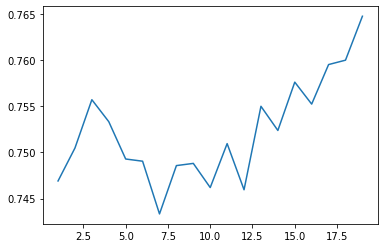

In [5]:
vals = pd.Series(range(1, 20), index=range(1, 20))
test_errs = vals.apply(get_cv_error_knn)

test_errs.plot.line()
test_errs.sort_values()

In [6]:
best_knn = KNeighborsClassifier(n_neighbors=19)
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.47      0.49       265
   SHA-3-256       0.51      0.55      0.53       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [7]:
def get_cv_error_mlp_iterations(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(max_iter=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

100
200
300
400
500


200    0.689495
300    0.699130
400    0.703193
100    0.704105
500    0.710504
dtype: float64

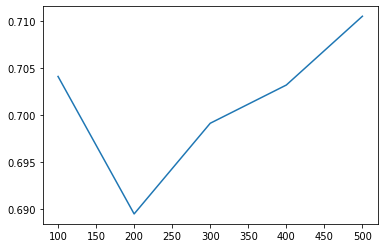

In [8]:
vals = pd.Series(range(100, 600, 100), index=range(100, 600, 100))
test_errs = vals.apply(get_cv_error_mlp_iterations)

test_errs.plot.line()
test_errs.sort_values()

In [9]:
def get_cv_error_mlp_hidden_layers(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(hidden_layer_sizes=k, max_iter=300)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

100
125
150
175
200
225


225    0.684251
100    0.687348
200    0.690374
150    0.694436
125    0.707364
175    0.711455
dtype: float64

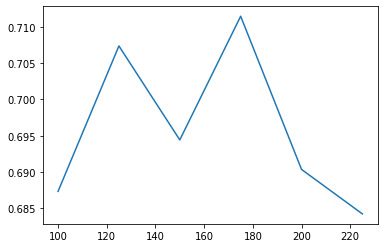

In [10]:
vals = pd.Series(range(100, 250, 25), index=range(100, 250, 25))
test_errs = vals.apply(get_cv_error_mlp_hidden_layers)

test_errs.plot.line()
test_errs.sort_values()

In [11]:
best_mlp = MLPClassifier(max_iter=500)
best_mlp.fit(X_train, y_train)


y_pred = best_mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      0.98      0.99       251
       SHA-1       0.98      0.99      0.98       269
     SHA-256       0.50      0.18      0.26       265
   SHA-3-256       0.50      0.83      0.62       265

    accuracy                           0.74      1050
   macro avg       0.74      0.74      0.71      1050
weighted avg       0.74      0.74      0.71      1050



In [12]:
def get_cv_error_descision_tree_maxDepth(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      DecisionTreeClassifier(max_depth=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


6     0.720632
5     0.725999
7     0.731288
8     0.731745
15    0.738897
14    0.739071
12    0.740309
16    0.740379
11    0.740622
23    0.741944
10    0.742353
22    0.742690
13    0.742722
24    0.743213
18    0.743869
9     0.743963
30    0.745218
29    0.746046
21    0.746213
20    0.746392
26    0.748072
19    0.748105
17    0.748162
27    0.749616
28    0.752722
25    0.753219
dtype: float64

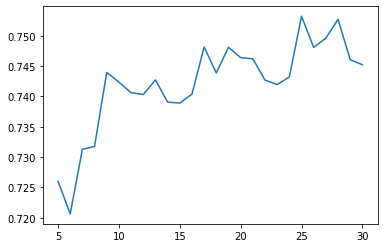

In [13]:
vals = pd.Series(range(5,31), index=range(5,31))
test_errs = vals.apply(get_cv_error_descision_tree_maxDepth)

test_errs.plot.line()
test_errs.sort_values()

In [14]:
def get_cv_error_descision_tree_maxFeatures(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      DecisionTreeClassifier(max_features=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

2
3
4
5
6
7
8
9
10
11
12
13
14
15


2     0.724157
4     0.730702
7     0.733125
3     0.734919
8     0.736836
13    0.737084
10    0.737342
6     0.738622
5     0.738808
11    0.741462
9     0.741502
15    0.743736
14    0.744080
12    0.745316
dtype: float64

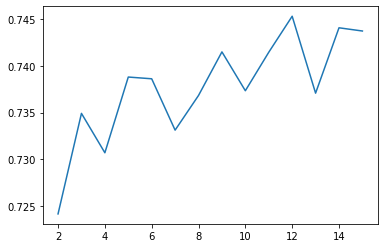

In [15]:
vals = pd.Series(range(2,16), index=range(2,16))
test_errs = vals.apply(get_cv_error_descision_tree_maxFeatures)

test_errs.plot.line()
test_errs.sort_values()

In [16]:
best_tree = DecisionTreeClassifier(max_depth=28)
best_tree.fit(X_train, y_train)


y_pred = best_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.50      0.49      0.50       265
   SHA-3-256       0.50      0.51      0.51       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [17]:
def get_cv_error_gbc_max_depth(n):
  print(n)
  # define pipeline
  pipeline = make_pipeline(
      GradientBoostingClassifier(max_depth=n)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


7     0.740655
20    0.740959
11    0.741152
19    0.741617
16    0.743629
18    0.744136
6     0.744827
17    0.745924
13    0.746173
5     0.746812
9     0.747132
8     0.747154
10    0.747351
15    0.748570
12    0.748902
14    0.748977
dtype: float64

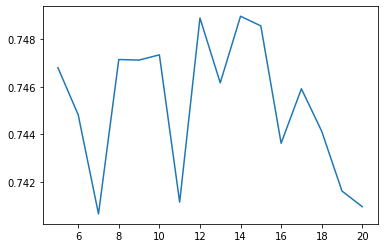

In [18]:
vals = pd.Series(range(5,21), index=range(5,21))
test_errs = vals.apply(get_cv_error_gbc_max_depth)

test_errs.plot.line()
test_errs.sort_values()

In [19]:
def get_cv_error_gbc_max_features(n):
  print(n)
  # define pipeline
  pipeline = make_pipeline(
      GradientBoostingClassifier(max_features=n)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

2
3
4
5
6
7
8
9
10


2     0.748980
10    0.752448
7     0.756897
8     0.757948
9     0.758298
5     0.758408
3     0.759575
6     0.761057
4     0.762831
dtype: float64

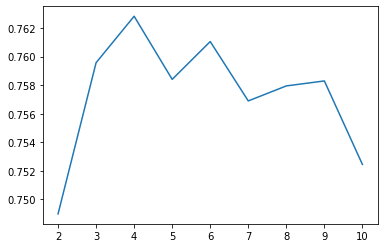

In [20]:
vals = pd.Series(range(2,11), index=range(2,11))
test_errs = vals.apply(get_cv_error_gbc_max_features)

test_errs.plot.line()
test_errs.sort_values()

In [21]:
best_gbc = GradientBoostingClassifier(max_features=8, )
best_gbc.fit(X_train, y_train)


y_pred = best_gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.43      0.47       265
   SHA-3-256       0.51      0.60      0.55       265

    accuracy                           0.75      1050
   macro avg       0.76      0.76      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [22]:
def get_cv_error_random_forest_estimators(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      RandomForestClassifier(n_estimators=k)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

200
400
600
800
1000
1200
1400
1600
1800


200     0.743680
1800    0.745104
1000    0.745268
1200    0.745537
800     0.745690
400     0.745927
1600    0.746006
600     0.749027
1400    0.749409
dtype: float64

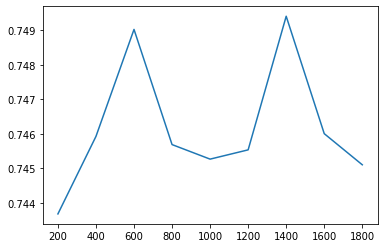

In [23]:
vals = pd.Series(range(200,2000,200), index=range(200,2000,200))
test_errs = vals.apply(get_cv_error_random_forest_estimators)

test_errs.plot.line()
test_errs.sort_values()

In [24]:
def get_cv_error_random_forest_depth(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      RandomForestClassifier(max_depth=k)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

10
20
30
40
50
60
70
80
90


60    0.740063
50    0.741795
80    0.743163
90    0.743979
70    0.744962
20    0.746197
40    0.746546
30    0.746916
10    0.751985
dtype: float64

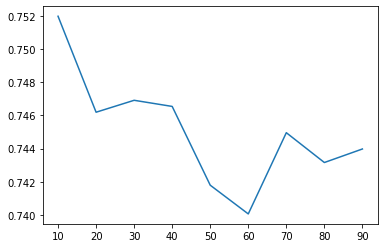

In [25]:
vals = pd.Series(range(10,100,10), index=range(10,100,10))
test_errs = vals.apply(get_cv_error_random_forest_depth)

test_errs.plot.line()
test_errs.sort_values()

In [26]:
best_rf = RandomForestClassifier(max_depth=10, n_estimators=800)
best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.50      0.36      0.42       265
   SHA-3-256       0.50      0.64      0.56       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.74      1050
weighted avg       0.75      0.75      0.74      1050



In [27]:
def get_cv_error_Ada_boost(n):
  print(n)
  # define pipeline
  pipeline = make_pipeline(
      AdaBoostClassifier(learning_rate=n, random_state=0)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


8     0.332955
15    0.336569
5     0.470043
6     0.663417
7     0.663417
9     0.663597
4     0.667843
10    0.669119
11    0.669119
12    0.669119
13    0.669119
14    0.669119
1     0.669456
3     0.671891
2     0.705226
dtype: float64

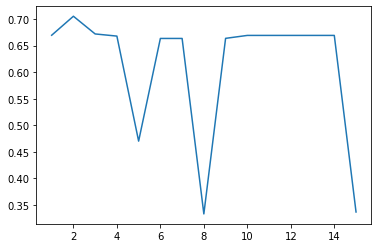

In [28]:
vals = pd.Series(range(1,16), index=range(1,16))
test_errs = vals.apply(get_cv_error_Ada_boost)

test_errs.plot.line()
test_errs.sort_values()

In [29]:
best_ada = AdaBoostClassifier(learning_rate=2)
best_ada.fit(X_train, y_train)


y_pred = best_ada.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.50      0.78      0.61       265
   SHA-3-256       0.50      0.22      0.31       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.73      1050
weighted avg       0.75      0.75      0.73      1050



# Picking an Algorithm and Further Fine Tuning

Most of the machine learning algorithms we used, after the pca components and scaling, resulted in the same results (for accuracy, f1score, etc). They hovered around 0.74 for reasons described below. We decided to pick the KNeighborsClassifier since it was relatively simple/fast to train and intuitively understand, and decided to further tune it.

In [30]:
def get_cv_error_knn(k, p, features=None):
  print(k, p)
  pipeline = make_pipeline(
      KNeighborsClassifier(n_neighbors=k, p=p)
  )

  if features != None:
    cv_errs = cross_val_score(pipeline, X=X_train[features], 
                              y=y_train,
                              scoring='accuracy', cv=10)
  else:
    cv_errs = cross_val_score(pipeline, X=X_train, 
                              y=y_train,
                              scoring='accuracy', cv=10)
    
  return cv_errs.mean()

1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2


7     0.743333
12    0.745952
10    0.746190
1     0.746905
8     0.748571
9     0.748810
6     0.749048
5     0.749286
2     0.750476
11    0.750952
14    0.752381
4     0.753333
13    0.755000
16    0.755238
3     0.755714
23    0.756905
15    0.757619
17    0.759524
27    0.759762
18    0.760000
30    0.760238
21    0.760476
28    0.760714
26    0.760952
25    0.761429
24    0.762381
29    0.762619
22    0.763095
19    0.764762
20    0.764762
dtype: float64

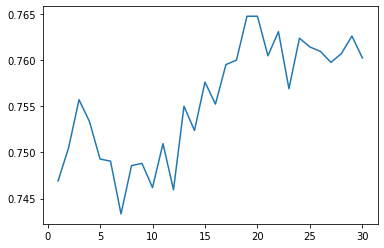

In [31]:
k_vals = {}
for i in range(1,31):
  k_vals[i] = get_cv_error_knn(i, 2)

test_errs_kvals = pd.Series(k_vals)

test_errs_kvals.plot.line()
test_errs_kvals.sort_values()

19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10


10    0.757619
7     0.759524
8     0.759524
9     0.759762
6     0.761905
5     0.762381
3     0.762857
2     0.764762
4     0.764762
dtype: float64

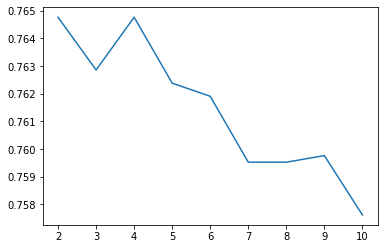

In [32]:
p_vals = {}
for i in range(2,11):
  p_vals[i] = get_cv_error_knn(test_errs_kvals.idxmax(),i)

test_errs_pvals = pd.Series(p_vals)

test_errs_pvals.plot.line()
test_errs_pvals.sort_values()

In [33]:
best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.47      0.49       265
   SHA-3-256       0.51      0.55      0.53       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [34]:
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 0.9981378026070763,
  'precision': 1.0,
  'recall': 0.9962825278810409,
  'support': 269},
 'SHA-256': {'f1-score': 0.48722986247544203,
  'precision': 0.5081967213114754,
  'recall': 0.4679245283018868,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5253623188405796,
  'precision': 0.5052264808362369,
  'recall': 0.5471698113207547,
  'support': 265},
 'accuracy': 0.7504761904761905,
 'macro avg': {'f1-score': 0.7526824959807744,
  'precision': 0.7533558005369281,
  'recall': 0.7528442168759206,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7503199970952851,
  'precision': 0.7510068081610893,
  'recall': 0.7504761904761905,
  'support': 1050}}

Rather than doing standard feature selection, we decided to run permutation based feature importance on the full model above and remove the features that were least important iteratively until we arrived at a final reduced model.

In [35]:
r = permutation_importance(best_knn, X_test, y_test, n_repeats=3)
r

{'importances': array([[ 0.00761905,  0.00952381,  0.00857143],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.11333333,  0.10380952,  0.11619048],
        [ 0.1152381 ,  0.11809524,  0.11904762],
        [ 0.48952381,  0.49619048,  0.49619048],
        [-0.00380952, -0.00095238,  0.        ],
        [ 0.00285714,  0.00285714,  0.00285714],
        [-0.0047619 , -0.00380952, -0.00380952],
        [ 0.00285714,  0.00190476,  0.00095238],
        [-0.00095238,  0.00095238,  0.00095238],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.00380952,  0.0047619 ,  0.00285714],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00190476, -0.00190476, -0.00380952],
        [-0.00190476,  0.        , -0.00095238],
        [ 0.00095238,  0.00095238,  0.00095238],
     

In [36]:
cols = []
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{X_train.columns[i]:<8}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
    cols.append(i)

hash len bits0.494 +/- 0.003
hash 1 bits0.117 +/- 0.002
hash 0 bits0.111 +/- 0.005
consecutiveCount0.009 +/- 0.001
consecutiveByte_b'\x01'0.005 +/- 0.002
consecutiveByte_b' '0.004 +/- 0.001
consecutiveByte_b'\x00'0.003 +/- 0.000
file type_.jpg0.003 +/- 0.000
file type_.pdf0.002 +/- 0.001
consecutiveByte_b'6'0.001 +/- 0.000
consecutiveByte_b'3'0.001 +/- 0.000
consecutiveByte_b'2'0.001 +/- 0.000


So, we should include those features (and features related to them, like common dummy variables) in the reduced model.

In [37]:
cols = list(set(cols).union(set(range(10,91))))
X_train.columns[cols]

Index(['consecutiveCount', 'hash 0 bits', 'hash 1 bits', 'hash len bits',
       'file type_.jpg', 'file type_.pdf', 'consecutiveByte_b"'"',
       'consecutiveByte_b' '', 'consecutiveByte_b'!'', 'consecutiveByte_b'"'',
       'consecutiveByte_b'('', 'consecutiveByte_b'-'', 'consecutiveByte_b'.'',
       'consecutiveByte_b'0'', 'consecutiveByte_b'1'', 'consecutiveByte_b'2'',
       'consecutiveByte_b'3'', 'consecutiveByte_b'4'', 'consecutiveByte_b'5'',
       'consecutiveByte_b'6'', 'consecutiveByte_b'7'', 'consecutiveByte_b'8'',
       'consecutiveByte_b'9'', 'consecutiveByte_b';'', 'consecutiveByte_b'>'',
       'consecutiveByte_b'?'', 'consecutiveByte_b'@'', 'consecutiveByte_b'A'',
       'consecutiveByte_b'B'', 'consecutiveByte_b'D'', 'consecutiveByte_b'O'',
       'consecutiveByte_b'P'', 'consecutiveByte_b'Q'', 'consecutiveByte_b'U'',
       'consecutiveByte_b'Y'', 'consecutiveByte_b'\\'',
       'consecutiveByte_b'\n'', 'consecutiveByte_b'\r'',
       'consecutiveByte_b'\x00'', '

In [38]:
X_train2 = X_train.iloc[:, cols]
X_test2 = X_test.iloc[:, cols]

best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train2, y_train)

y_pred = best_knn.predict(X_test2)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 269},
 'SHA-256': {'f1-score': 0.5058823529411764,
  'precision': 0.5265306122448979,
  'recall': 0.4867924528301887,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5418181818181819,
  'precision': 0.5228070175438596,
  'recall': 0.5622641509433962,
  'support': 265},
 'accuracy': 0.76,
 'macro avg': {'f1-score': 0.7619251336898396,
  'precision': 0.7623344074471894,
  'recall': 0.7622641509433963,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7596577540106951,
  'precision': 0.760070925613353,
  'recall': 0.76,
  'support': 1050}}

This actually increased our F-1 score while having less features! Definitely better than the previous model. Running feature importance again:

In [39]:
r = permutation_importance(best_knn, X_test2, y_test, n_repeats=3)

cols = []
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{X_train2.columns[i]:<8}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
    cols.append(i)

hash len bits0.494 +/- 0.010
hash 0 bits0.129 +/- 0.011
hash 1 bits0.126 +/- 0.011
consecutiveByte_b'\n'0.006 +/- 0.003
consecutiveByte_b'\x01'0.004 +/- 0.002
consecutiveByte_b'\x00'0.004 +/- 0.001
consecutiveByte_b'2'0.001 +/- 0.000
consecutiveByte_b'6'0.001 +/- 0.000


It seems like all the features mentioned earlier are still significant. Therefore, we have found our most reduced model. As an aside, let's see what would happen in 2 cases: (a) where we include the PCA components, and (b) where our model only includes the length of the hash.

In [40]:
X_train3 = X_train2.join(X_train.iloc[:, [91,92]])
X_test3 = X_test2.join(X_test.iloc[:, [91,92]])

best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train3, y_train)

y_pred = best_knn.predict(X_test3)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 0.9981378026070763,
  'precision': 1.0,
  'recall': 0.9962825278810409,
  'support': 269},
 'SHA-256': {'f1-score': 0.4741035856573705,
  'precision': 0.5021097046413502,
  'recall': 0.4490566037735849,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5259391771019677,
  'precision': 0.5,
  'recall': 0.5547169811320755,
  'support': 265},
 'accuracy': 0.7476190476190476,
 'macro avg': {'f1-score': 0.7495451413416037,
  'precision': 0.7505274261603375,
  'recall': 0.7500140281966754,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7471527628881219,
  'precision': 0.7481514968856742,
  'recall': 0.7476190476190476,
  'support': 1050}}

Adding the principal components of the file distribution of bytes leads to a slightly lower f-1 score. Even if the decrease is insignificant, we prefer models with less features, so the earlier model is still better.

In [41]:
X_train4 = X_train[['hash len']]
X_test4 = X_test[['hash len']]

best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train4, y_train)

y_pred = best_knn.predict(X_test4)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 269},
 'SHA-256': {'f1-score': 0.6666666666666666,
  'precision': 0.5,
  'recall': 1.0,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 265},
 'accuracy': 0.7476190476190476,
 'macro avg': {'f1-score': 0.6666666666666666,
  'precision': 0.625,
  'recall': 0.75,
  'support': 1050},
 'weighted avg': {'f1-score': 0.6634920634920635,
  'precision': 0.6214285714285714,
  'recall': 0.7476190476190476,
  'support': 1050}}

Predicting only on the hash length significantly decreases the f1-score. Therefore, only predicting on the hash length does not yield an appropriate model.

Finally, we consider how much better our model does than a model which would randomly guess:

In [42]:
cols = list(range(0, 5))
cols.extend([i for i in range(10, 91)])
X_train.columns[cols]

Index(['consecutiveCount', 'hash len', 'hash 0 bits', 'hash 1 bits',
       'hash len bits', 'consecutiveByte_b"'"', 'consecutiveByte_b' '',
       'consecutiveByte_b'!'', 'consecutiveByte_b'"'', 'consecutiveByte_b'('',
       'consecutiveByte_b'-'', 'consecutiveByte_b'.'', 'consecutiveByte_b'0'',
       'consecutiveByte_b'1'', 'consecutiveByte_b'2'', 'consecutiveByte_b'3'',
       'consecutiveByte_b'4'', 'consecutiveByte_b'5'', 'consecutiveByte_b'6'',
       'consecutiveByte_b'7'', 'consecutiveByte_b'8'', 'consecutiveByte_b'9'',
       'consecutiveByte_b';'', 'consecutiveByte_b'>'', 'consecutiveByte_b'?'',
       'consecutiveByte_b'@'', 'consecutiveByte_b'A'', 'consecutiveByte_b'B'',
       'consecutiveByte_b'D'', 'consecutiveByte_b'O'', 'consecutiveByte_b'P'',
       'consecutiveByte_b'Q'', 'consecutiveByte_b'U'', 'consecutiveByte_b'Y'',
       'consecutiveByte_b'\\'', 'consecutiveByte_b'\n'',
       'consecutiveByte_b'\r'', 'consecutiveByte_b'\x00'',
       'consecutiveByte_b'\x01''

In [43]:
# explicitly recreasting final model
X_train_final = X_train[X_train.columns[cols]]
X_test_final = X_test[X_test.columns[cols]]

final_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
final_knn.fit(X_train_final, y_train)

y_pred = final_knn.predict(X_test_final)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 269},
 'SHA-256': {'f1-score': 0.5028790786948176,
  'precision': 0.51171875,
  'recall': 0.49433962264150944,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5194805194805195,
  'precision': 0.5109489051094891,
  'recall': 0.5283018867924528,
  'support': 265},
 'accuracy': 0.7533333333333333,
 'macro avg': {'f1-score': 0.7555898995438344,
  'precision': 0.7556669137773723,
  'recall': 0.7556603773584906,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7532621843013946,
  'precision': 0.7533399320038234,
  'recall': 0.7533333333333333,
  'support': 1050}}

In [44]:
y_test.value_counts(normalize=True)

SHA-1        0.256190
SHA-3-256    0.252381
SHA-256      0.252381
MD5          0.239048
Name: hash type, dtype: float64

The highest accuracy you could attain with a model that chooses randomly is 0.256190. Our final model has an f-1 score of 0.7555898995438344, which is much better than the randomized model.

However, it is important to note that our final model mostly takes into account the hash length (in bits), the number of 0 bits, and the number of 1 bits. Thus, it is mostly leveraging the distinct hash lengths of the various algorithms to predict the hash. However, there is a slgiht contribution from the consecutive byte value and consecutive byte count features, which indicates that there might be a "periodic" nature in the hash algorithm that our model was able to pick up on. Interestingly, the file size, file type, etc. were not essential features. These results, and more, are expanded upon and interpreted further in our report.

Therefore, given that we are predicting mostly on the number of total/0/1 bits in the hash, we determine that hash algorithms are MOSTLY secure. However, the other features indicate further work that could be done with respect to identifying hash algorithms. This is once again expanded in the report.